In [1]:
import pandas as pd

import cancer_data
import many

import pyranges

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
ccle_exonusage = cancer_data.load("ccle_exonusage")
ccle_proteomics = cancer_data.load("ccle_proteomics")
ccle_genex = cancer_data.load("ccle_gene_tpm")

merged_ccle_info = pd.read_csv("../data/supplementary/S1_merged-ccle-info.txt",sep="\t",index_col=0)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [101]:
msi_cell_lines = set(merged_ccle_info.index[merged_ccle_info["MSI"]==True])
non_msi_cell_lines = set(merged_ccle_info.index[merged_ccle_info["MSI"]==False])

ccle_exonusage_msi = ccle_exonusage[ccle_exonusage.index.isin(msi_cell_lines)]
ccle_exonusage_non_msi = ccle_exonusage[ccle_exonusage.index.isin(non_msi_cell_lines)]

# Compute differences

In [3]:
msi_prot_diffs = many.stats.mat_mwu_naive(
    ccle_proteomics,
    merged_ccle_info["MSI"],
    effect="rank_biserial",
    melt=True,
    pbar=True,
)
msi_prot_diffs = msi_prot_diffs.reset_index()
msi_prot_diffs = msi_prot_diffs.rename({"a_col": "protein"}, axis=1).drop(
    "b_col", axis=1
)
msi_prot_diffs.to_csv("../data/supplementary/S5-a__msi-prot-diffs.txt", sep="\t")

msi_exon_diffs = many.stats.mat_mwu_naive(
    ccle_exonusage,
    merged_ccle_info["MSI"],
    effect="rank_biserial",
    melt=True,
    pbar=True,
)
msi_exon_diffs = msi_exon_diffs.reset_index()
msi_exon_diffs = msi_exon_diffs.rename({"a_col": "exon"}, axis=1).drop("b_col", axis=1)
msi_exon_diffs.to_csv("../data/intermediate/S5-b_msi-exon-diffs.txt", sep="\t")

  0%|          | 0/12755 [00:00<?, ?it/s]

  0%|          | 0/310754 [00:00<?, ?it/s]

# CCLE BAMs

In [4]:
ccle_samples = pd.read_csv("../data/raw/fullccle_samples.csv")
wgs_samples = ccle_samples[ccle_samples["datatype"] == "wgs"]
wgs_samples = wgs_samples.sort_values(by=["arxspan_id", "version", "size"])
wgs_samples = wgs_samples.drop_duplicates(subset=["arxspan_id"], keep="first")

In [5]:
msi_exons = msi_exon_diffs.copy()[msi_exon_diffs["qval"] >= 4]

msi_exons["gene"] = msi_exons["exon"].map(lambda x: x.split("_")[-1])
msi_exons["exon_chrom"] = msi_exons["exon"].map(lambda x: x.split("_")[-4][3:])
msi_exons["exon_start"] = msi_exons["exon"].map(lambda x: x.split("_")[-3])
msi_exons["exon_end"] = msi_exons["exon"].map(lambda x: x.split("_")[-2])

msi_exons["exon"] = (
    msi_exons["exon_chrom"]
    + "_"
    + msi_exons["exon_start"]
    + "_"
    + msi_exons["exon_end"]
)

msi_exons["exon_start"] = msi_exons["exon_start"].astype(int)
msi_exons["exon_end"] = msi_exons["exon_end"].astype(int)

msi_exons = msi_exons.drop_duplicates(subset=["exon"])

In [14]:
def get_exon_bounds(row, padding=1000):

    if row["exon_start"] <= row["exon_end"]:
        row["bound_start"] = row["exon_start"] - padding
        row["bound_end"] = row["exon_end"] + padding

    elif row["exon_start"] >= row["exon_end"]:
        row["bound_start"] = row["exon_end"] - padding
        row["bound_end"] = row["exon_start"] + padding

    return row


msi_exons = msi_exons.apply(get_exon_bounds, axis=1)

In [15]:
msi_exons[["exon_chrom", "bound_start", "bound_end"]].to_csv(
    "../scripts/MSI_exon_bounds.bed", sep="\t", header=False, index=False
)
msi_exons[["exon_chrom", "bound_start", "bound_end"]].to_csv(
    "../data/raw/MSI_exon_bounds.bed", sep="\t", header=False, index=False
)

In [16]:
with open("../scripts/wgs_paths.txt", "w") as f:
    for bam_path in list(wgs_samples["internal_bam_filepath"]):
        f.write(bam_path + "\n")

with open("../scripts/wgs_ids.txt", "w") as f:
    for bam_path in list(wgs_samples["arxspan_id"]):
        f.write(bam_path + "\n")

In [17]:
with open("../scripts/7_fetch-msi-slices.sh", "w") as f:
    for bam_path, ach_id in zip(
        list(wgs_samples["internal_bam_filepath"]), list(wgs_samples["arxspan_id"])
    ):

        f.write(
            "GCS_OAUTH_TOKEN=$(gcloud auth application-default print-access-token) samtools view -b -h -M -L ../data/raw/MSI_exon_bounds.bed {} > ../data/raw/WGS_slices/{}.bam\n".format(
                bam_path, ach_id
            )
        )

# Read mutations

In [8]:
msi_exon_calls = pd.read_csv(
    "../data/intermediate/msi_exon_calls/msi_exon_calls_filtered.txt",
    sep="\t",
    names=["chrom", "pos", "sample", "ref", "alt", "genotype"],
)

msi_exon_calls["snp"] = (
    msi_exon_calls["chrom"].astype(str)
    + "_"
    + msi_exon_calls["pos"].astype(str)
    + "_"
    + msi_exon_calls["ref"].astype(str)
    + ">"
    + msi_exon_calls["alt"].astype(str)
)

wgs_sample_ids = pd.read_csv(
    "../scripts/wgs_ids_samples.txt", sep="\t", names=["ach_id", "sample_name", "cn_bi"]
)
wgs_sample_map = dict(zip(wgs_sample_ids["sample_name"], wgs_sample_ids["ach_id"]))
wgs_sample_map["Detroit 562"] = "ACH-000207"

msi_exon_calls["ach_id"] = msi_exon_calls["sample"].apply(lambda x: wgs_sample_map[x])

msi_exon_calls["mut_site"] = (
    msi_exon_calls["chrom"] + "_" + msi_exon_calls["pos"].astype(str)
)
msi_exon_calls["value"] = 1
msi_exon_mut_mat = pd.pivot_table(
    msi_exon_calls, values="value", index=["ach_id"], columns="snp", fill_value=0
)

In [9]:
msi_exon_diffs = pd.read_csv(
    "../data/intermediate/S5-b_msi-exon-diffs.txt", sep="\t", index_col=0
)
msi_exon_diffs["exon"] = msi_exon_diffs["exon"].apply(
    lambda x: x.replace("_1.13e+08_", "_113000000_")
)

In [10]:
msi_exon_calls_unique = msi_exon_calls[["chrom", "pos", "snp"]].rename(
    {"chrom": "Chromosome", "pos": "Start", "snp": "SNP"}, axis=1
)
msi_exon_calls_unique = msi_exon_calls_unique.drop_duplicates(subset=["SNP"])

msi_exon_calls_unique["End"] = msi_exon_calls_unique["Start"]+1

msi_exon_calls_unique = pyranges.PyRanges(msi_exon_calls_unique)

In [11]:
msi_exon_diffs[
    ["gene", "strand", "chrom", "Start", "End", "ens_gene"]
] = msi_exon_diffs["exon"].str.rsplit("_", expand=True, n=5)

msi_exon_diffs["Start"] = msi_exon_diffs["Start"].astype(int)
msi_exon_diffs["End"] = msi_exon_diffs["End"].astype(int)

msi_exon_diffs[["Start","End"]] = np.sort(msi_exon_diffs[["Start","End"]], axis=1)

msi_exon_diffs["Chromosome"] = msi_exon_diffs["chrom"].str.split("chr").str[-1]

padding = 1000
msi_exon_diffs["Start"] = msi_exon_diffs["Start"] - padding
msi_exon_diffs["End"] = msi_exon_diffs["End"] + padding

In [12]:
msi_exon_bounds = pyranges.PyRanges(
    msi_exon_diffs[["Chromosome", "Start", "End", "exon"]]
)

In [13]:
exon_matched = msi_exon_bounds.join(
    msi_exon_calls_unique, strandedness=False, suffix="_SNP"
)
snps_by_exon = exon_matched.df.groupby("exon")["SNP"].apply(list).to_dict()

In [14]:
msi_exon_diffs["snps"] = msi_exon_diffs["exon"].apply(lambda x: snps_by_exon.get(x,[]))

In [15]:
exon_matched_snps = msi_exon_diffs[msi_exon_diffs["snps"].apply(len) > 0]

exon_matched_snps = exon_matched_snps.explode("snps")


def get_associations(row):

    exon = row["exon"]
    snp = row["snps"]

    snp_values = msi_exon_mut_mat[snp]

    if snp_values.astype(int).sum() < 5:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)

    exon_values = ccle_exonusage[exon]

    corr_result = many.stats.mat_mwu_naive(
        ccle_exonusage[exon],
        msi_exon_mut_mat[snp],
        melt=True,
        effect="rank_biserial",
        use_continuity=True,
    )

    corr_result = corr_result.iloc[0].to_dict()

    return (
        corr_result["rank_biserial"],
        corr_result["pval"],
        corr_result["qval"],
        corr_result["pos_n"],
        corr_result["neg_n"],
    )

In [16]:
(
    exon_matched_snps["exon_snp_rank_biserial"],
    exon_matched_snps["exon_snp_pval"],
    exon_matched_snps["exon_snp_qval"],
    exon_matched_snps["exon_snp_pos_n"],
    exon_matched_snps["exon_snp_neg_n"],
) = zip(*exon_matched_snps.progress_apply(get_associations,axis=1))

  0%|          | 0/11764 [00:00<?, ?it/s]

In [17]:
filtered_exon_snps = exon_matched_snps[exon_matched_snps["exon_snp_qval"]>2]

In [112]:
filtered_exon_snps.to_csv("~/Desktop/filtered_exon_snps.txt",sep="\t")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exon_snp_rank_biserial', ylabel='exon_snp_qval'>

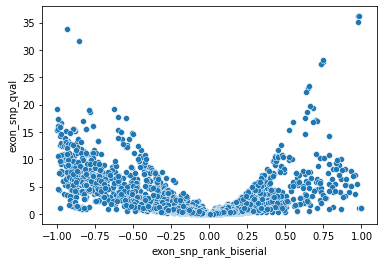

In [114]:
sns.scatterplot(exon_matched_snps["exon_snp_rank_biserial"],exon_matched_snps["exon_snp_qval"])

In [19]:
correlated_exons = ccle_exonusage[filtered_exon_snps["exon"]]
correlated_snps = msi_exon_mut_mat[filtered_exon_snps["snps"]]

msi_cell_lines = set(merged_ccle_info.index[merged_ccle_info["MSI"]==True])

correlated_exons = correlated_exons[correlated_exons.index.isin(msi_cell_lines)]
correlated_snps = correlated_snps[correlated_snps.index.isin(msi_cell_lines)]

correlated_exons, correlated_snps = correlated_exons.align(correlated_snps,join="inner",axis=0)


In [105]:
def make_exon_msi_plots(exon, gene, protein, mutation):

    select_exon = ccle_exonusage[exon]
    select_exon_msi = ccle_exonusage_msi[exon]
    select_exon_non_msi = ccle_exonusage_non_msi[exon]

    select_protein = ccle_proteomics[protein]

    select_gene = ccle_genex[gene]
    select_mutation = msi_exon_mut_mat[mutation].astype(bool).astype(str)

    plt.figure(figsize=(12, 4))

    ax = plt.subplot(141)
    sns.scatterplot(select_exon, select_protein, hue=select_mutation)
    ax.set_title("Exonusage vs protein")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax = plt.subplot(142)
    sns.scatterplot(select_exon, select_gene, hue=select_mutation)
    ax.set_title("Exonusage vs mRNA")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax = plt.subplot(143)
    sns.scatterplot(select_exon_msi, select_gene, hue=select_mutation)
    ax.set_title("Exonusage vs mRNA (MSI only)")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    ax = plt.subplot(144)
    sns.scatterplot(select_exon_non_msi, select_gene, hue=select_mutation)
    ax.set_title("Exonusage vs mRNA (non-MSI only)")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)


/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid 

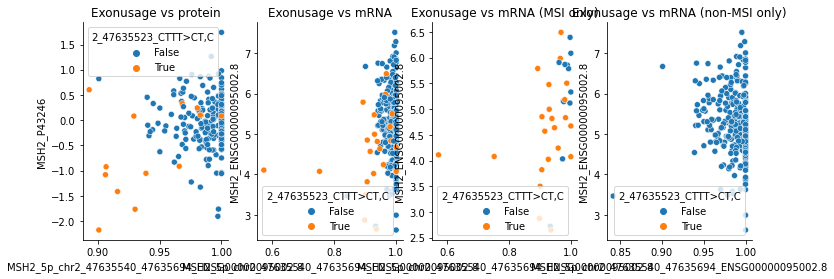

In [106]:
make_exon_msi_plots(
    "MSH2_5p_chr2_47635540_47635694_ENSG00000095002.8",
    "MSH2_ENSG00000095002.8",
    "MSH2_P43246",
    "2_47635523_CTTT>CT,C",
)

plt.savefig("../plots/MSH2_polya_truncations.pdf", bbox_inches="tight")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid 

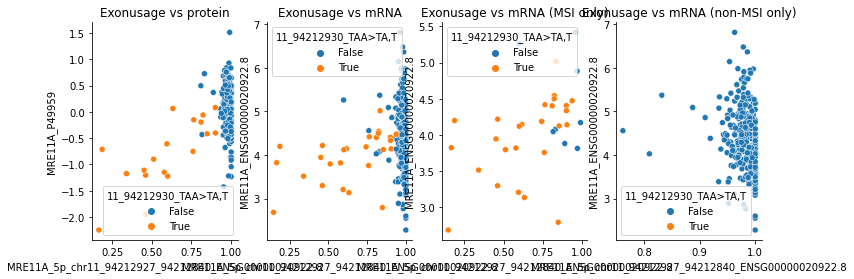

In [107]:
make_exon_msi_plots(
    "MRE11A_5p_chr11_94212927_94212840_ENSG00000020922.8",
    "MRE11A_ENSG00000020922.8",
    "MRE11A_P49959",
    "11_94212930_TAA>TA,T",
)

plt.savefig("../plots/MRE11A_polya_truncations.pdf", bbox_inches="tight")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid 

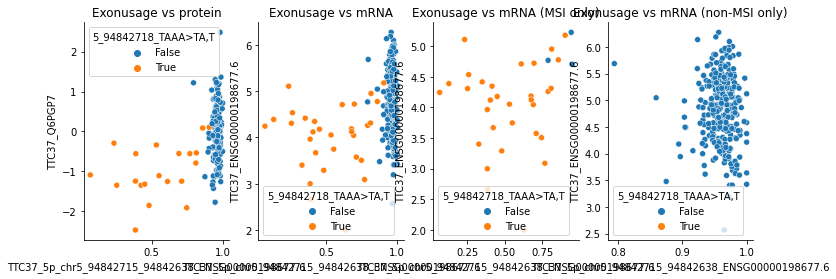

In [108]:
make_exon_msi_plots(
    "TTC37_5p_chr5_94842715_94842638_ENSG00000198677.6",
    "TTC37_ENSG00000198677.6",
    "TTC37_Q6PGP7",
    "5_94842718_TAAA>TA,T",
)

plt.savefig("../plots/TTC37_polya_truncations.pdf", bbox_inches="tight")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid 

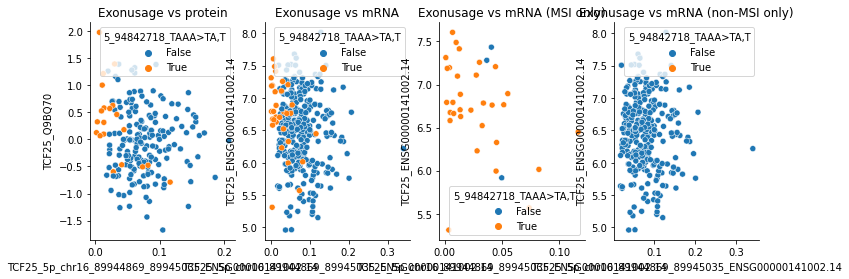

In [109]:
make_exon_msi_plots(
    "TCF25_5p_chr16_89944869_89945035_ENSG00000141002.14",
    "TCF25_ENSG00000141002.14",
    "TCF25_Q9BQ70",
    "5_94842718_TAAA>TA,T",
)

plt.savefig("../plots/TCF25_polya_truncations.pdf", bbox_inches="tight")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid 

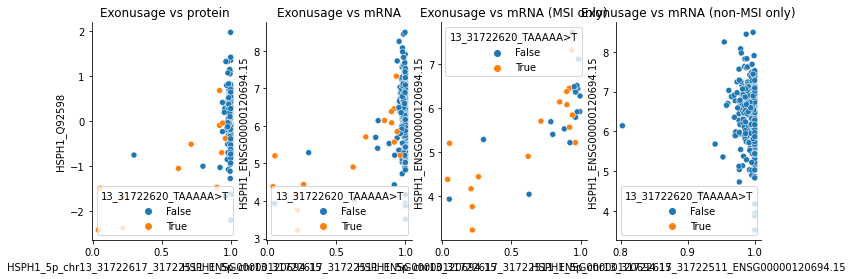

In [110]:
make_exon_msi_plots(
    "HSPH1_5p_chr13_31722617_31722511_ENSG00000120694.15",
    "HSPH1_ENSG00000120694.15",
    "HSPH1_Q92598",
    "13_31722620_TAAAAA>T",
)

plt.savefig("../plots/HSPH1_polya_truncations.pdf", bbox_inches="tight")